In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import matplotlib.image as img
import gc
from sklearn.metrics import classification_report
import cv2
from tensorflow import keras
from tensorflow.keras.layers import *
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
label = []
file_path = []
training_path = "archive/AugmentedAlzheimerDataset"
categories = os.listdir(training_path)
for category in categories:
    for file in os.listdir(os.path.join(training_path, category)):
        file_path.append(os.path.join(training_path, category, file))
        label.append(category)
final_data = pd.DataFrame(list(zip(file_path, label)), columns = ["file_path", "label"])
le = preprocessing.LabelEncoder()
le.fit(final_data["label"])

LabelEncoder()

In [3]:
images = []
for i in final_data.iterrows():
    image = cv2.imread(i[1]["file_path"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (150,150))
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    images.append(image)
images = np.array(images, dtype = "float32")

<AxesSubplot:ylabel='label'>

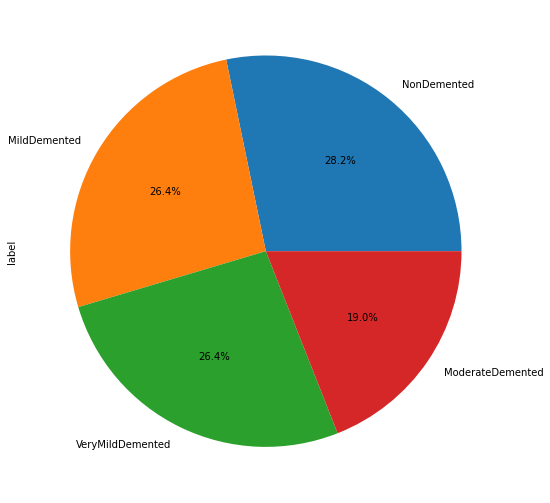

In [4]:
pie, ax = plt.subplots(figsize=[15,9])
(final_data["label"].value_counts()).plot.pie(autopct = "%.1f%%")

In [5]:
final_data["label"] = le.transform(final_data["label"])

In [6]:
x_train, x_test, y_train, y_test = tts(images, label, test_size = 0.3) #Train test split
x_train, x_val, y_train, y_val = tts(x_train, y_train, test_size = 0.15) #Train validation Split

In [7]:
x_train = np.array(x_train).astype('float32')
x_test = np.array(x_test).astype('float32')
y_train = np.array(y_train)
y_test = np.array(y_test)
x_val = np.array(x_val).astype('float32')
y_val = np.array(y_val)

y_train = le.transform(y_train).astype('float32')
y_test = le.transform(y_test).astype('float32')
y_val = le.transform(y_val).astype('float32')

In [8]:
print("Training Data Shape is: ", str(x_train.shape), str(y_train.shape))
print("Validation Data Shape is: ", str(x_val.shape), str(y_val.shape))
print("Testing Data Shape is: ", str(x_test.shape), str(y_test.shape))

Training Data Shape is:  (20219, 150, 150, 3) (20219,)
Validation Data Shape is:  (3569, 150, 150, 3) (3569,)
Testing Data Shape is:  (10196, 150, 150, 3) (10196,)


In [9]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(128, kernel_size=(3,3), input_shape = (150,150,3), activation = "relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(3,3), activation = "relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, kernel_size=(3,3), activation = "relu"))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
print(model.summary())

# Compile the model
model.compile(loss = "SparseCategoricalCrossentropy", 
          optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), 
          metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 32)       0

In [10]:
acc_per_fold = []
loss_per_fold = []
histories = []
kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1
for train, test in kfold.split(x_train, y_train):
    gc.collect()
    gc.collect()
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(x_train[train], y_train[train],
                        validation_data= [x_val, y_val],
                          batch_size=2,
                          epochs=5,
                          verbose=1)
    histories.append(history)
    # Generate generalization metrics
    scores = model.evaluate((x_train)[test], (y_train)[test], verbose=0)
    print(f"Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1
    gc.collect()
    gc.collect()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
9099/9099 [==============================] - 67s 7ms/step - loss: 1.3475 - accuracy: 0.3145 - val_loss: 1.2593 - val_accuracy: 0.3959
Epoch 2/5
9099/9099 [==============================] - 57s 6ms/step - loss: 1.2449 - accuracy: 0.4134 - val_loss: 1.1322 - val_accuracy: 0.5559
Epoch 3/5
9099/9099 [==============================] - 59s 6ms/step - loss: 1.1312 - accuracy: 0.4911 - val_loss: 0.9804 - val_accuracy: 0.5920
Epoch 4/5
9099/9099 [==============================] - 58s 6ms/step - loss: 1.0307 - accuracy: 0.5362 - val_loss: 0.8969 - val_accuracy: 0.6156
Epoch 5/5
9099/9099 [==============================] - 58s 6ms/step - loss: 0.9497 - accuracy: 0.5715 - val_loss: 0.8321 - val_accuracy: 0.6321
Score for fold 1: loss of 0.8084144592285156; accuracy of 64.2433226108551%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5


9099/9099 [==============================] - 58s 6ms/step - loss: 0.1060 - accuracy: 0.9620 - val_loss: 0.3556 - val_accuracy: 0.9022
Epoch 2/5
9099/9099 [==============================] - 58s 6ms/step - loss: 0.1027 - accuracy: 0.9620 - val_loss: 0.3026 - val_accuracy: 0.9000
Epoch 3/5
9099/9099 [==============================] - 58s 6ms/step - loss: 0.0932 - accuracy: 0.9668 - val_loss: 0.3316 - val_accuracy: 0.9028
Epoch 4/5
9099/9099 [==============================] - 58s 6ms/step - loss: 0.0931 - accuracy: 0.9669 - val_loss: 0.3683 - val_accuracy: 0.9019
Epoch 5/5
9099/9099 [==============================] - 59s 6ms/step - loss: 0.0870 - accuracy: 0.9689 - val_loss: 0.3484 - val_accuracy: 0.8955
Score for fold 10: loss of 0.02576063759624958; accuracy of 99.40623641014099%


In [11]:
predictions = model.evaluate(x_test, y_test)

319/319 [==============================] - 5s 16ms/step - loss: 0.3431 - accuracy: 0.8999


In [12]:
predictions = model.predict(x_test)
print(classification_report(y_test, np.argmax(predictions, axis = 1)))

319/319 [==============================] - 4s 13ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90      2808
         1.0       0.96      1.00      0.98      1975
         2.0       0.91      0.87      0.89      2876
         3.0       0.83      0.86      0.85      2537

    accuracy                           0.90     10196
   macro avg       0.90      0.91      0.90     10196
weighted avg       0.90      0.90      0.90     10196



In [13]:
histories[0]

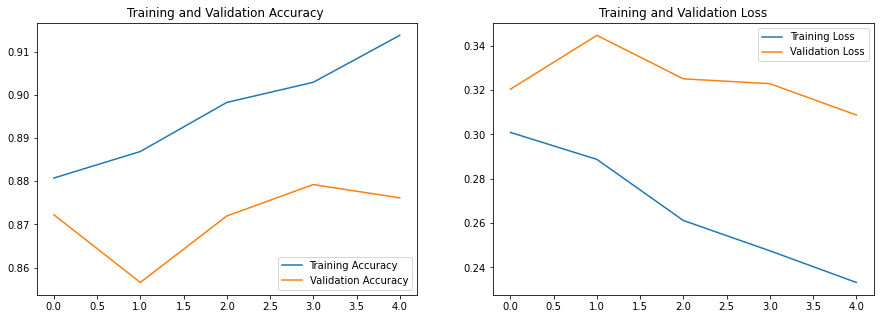

In [14]:
history = histories[5]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy ')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()